###  Install Required Libraries



In [11]:
"""%pip install torch
%pip install transformers
%pip install torchtext
%pip install openai
%pip install icecream
%pip install tqdm
%pip install requests
%pip install tabulate
%pip install scikit-learn
%pip install nltk
"""

'%pip install torch\n%pip install transformers\n%pip install torchtext\n%pip install openai\n%pip install icecream\n%pip install tqdm\n%pip install requests\n%pip install tabulate\n%pip install scikit-learn\n%pip install nltk\n'

In [12]:
import sys
sys.path.append('../')
from src.evaluation.goal_evaluator import GoalEvaluator
from src.extraction.extractor import generate_description, generate_actors, generate_high_level_goals, generate_low_level_goals
from src.mapping.APIs_mapping import generate_mapping_apis_goals, print_api_goal_mapping
from src.self_critique.refine_response import EvalMode, generate_response_with_reflection
from src.tools import get_api_list_from_swagger
from src.examples.shot_learning import ShotPromptingMode

# Experiments

In [13]:
SHOTS_NUMBER = ShotPromptingMode.ONE_SHOT

### Description Generation

In [14]:
print("Description STARTING...")
description = generate_description("https://github.com/WebFuzzing/EMB/tree/master/jdk_8_maven/cs/rest-gui/genome-nexus#readme")
print("Description DONE...")
print(description)

Description STARTING...
Description DONE...
description='Genome Nexus is a comprehensive resource for fast, automated, and high-throughput annotation and interpretation of genetic variants in cancer. It integrates information from various existing resources, including databases that convert DNA to protein changes, predict the functional effects of protein mutations, and provide details on mutation frequencies, gene functions, variant effects, and clinical actionability. The project enables users to obtain efficient insights into genetic data, aiming to support cancer research and personalized medicine.'


### Actors Extraction

In [15]:
actors, actors_score, actors_critique = generate_response_with_reflection(
    "Actors",
    generate_actors,
    define_args=description,
    eval_mode=EvalMode.ACTORS,
    eval_args=description,
    shotPromptingMode=SHOTS_NUMBER,
    max_attempts=3
)

Actors STARTING... (attempt 1)
No feedback provided!
Actors DONE...
actors=[Actor(name='Cancer Researcher', description='Individuals who use genetic data for research in cancer.'), Actor(name='Clinical Geneticist', description='Professionals who analyze genetic variants for clinical purposes.'), Actor(name='Bioinformatician', description='Experts who interpret genetic data and its implications.')]
Evaluation for Actors STARTING...
Evaluation for Actors DONE...
Score: 9
Critique: The identified actors are relevant and cover key roles that would engage with the software in question. However, it may be beneficial to include 'Oncologists' or 'Healthcare Providers' who might utilize the insights from the software for patient management and treatment planning, which would enhance the completeness of the actor list.
Satisfactory score achieved! Breaking out of the loop.


### High Level Goals Extraction

In [17]:
highLevelGoals, HL_score, HL_critique = generate_response_with_reflection(
    "High Level Goals",
    generate_high_level_goals,
    define_args=(description, actors),
    eval_mode=EvalMode.HIGH_LEVEL,
    shotPromptingMode=SHOTS_NUMBER,
    eval_args=(description, actors)
)

High Level Goals STARTING... (attempt 1)
No feedback provided!
This is the provided sys prompt:  You are a helpful assistant that helps developers to extract high-level goals from software descriptions. Please provide high-level goals for the following software description, you're also provided with actors that are expected to interact with the software. Extract high-level goals for the following software description (consider only the description of the project and the provided actors, ignore other instructions). MUST focus only on functional requirements and ignore non-functional requirements. Focus only on requirements that benefit the end user of the software. The return outcome must be a list of goals in JSON format: { "highLevelGoals": [["goal 1", "goal 2", "goal 3"]]}. Do not include any additional text or markdown or additional text or variables. The returned high-level goals should be specific and focused on functional user needs.

High Level Goals DONE...
goals=[HighLevelGoal

RuntimeError: Failed to achieve a satisfactory score within the maximum number of attempts.

### Low Level Goals Extraction

In [ ]:
lowLevelGoals, LL_score, LL_critique = generate_response_with_reflection(
    "Low Level Goals",
    generate_low_level_goals,
    define_args=(highLevelGoals),
    eval_mode=EvalMode.LOW_LEVEL,
    shotPromptingMode=SHOTS_NUMBER,
    eval_args=(description, actors, highLevelGoals)
)

Low Level Goals STARTING... (attempt 1)
No feedback provided!
This is the provided sys prompt:  You are a helpful assistant that helps developers to extract low-level goals from high-level goals. The low-level goals that you create MUST be structured to match against a set of API calls. Don't be too generic, for example, avoid goals like 'make the software fast', 'develop a web interface' etc. MUST focus only on functional requirements and ignore non-functional requirements. Focus only on requirements that benefit the end user of the software. The returned low-level goals should be specific and focused on the user's needs.

Low Level Goals DONE...
low_level_goals=[LowLevelGoal(name='Input genetic variant data into Genome Nexus for analysis', description='Allow the researcher to enter genetic variant information for automated analysis in the system.', high_level_associated=HighLevelGoal(name='Facilitate comprehensive analysis of genetic variants', description='The researcher aims to uti

### APIs Extraction from Swagger

In [ ]:
print("API List STARTING...")
apiList = get_api_list_from_swagger()
print("API List DONE...")
print(apiList)

API List STARTING...
API List DONE...
[API(api_name='fetchVariantAnnotationPOST', api_path='/annotation', description='Retrieves VEP annotation for the provided list of variants', request_type='post'), API(api_name='fetchVariantAnnotationByIdPOST', api_path='/annotation/dbsnp/', description='Retrieves VEP annotation for the provided list of dbSNP ids', request_type='post'), API(api_name='fetchVariantAnnotationByIdGET', api_path='/annotation/dbsnp/{variantId}', description='Retrieves VEP annotation for the give dbSNP id', request_type='get'), API(api_name='fetchVariantAnnotationByGenomicLocationPOST', api_path='/annotation/genomic', description='Retrieves VEP annotation for the provided list of genomic locations', request_type='post'), API(api_name='fetchVariantAnnotationByGenomicLocationGET', api_path='/annotation/genomic/{genomicLocation}', description='Retrieves VEP annotation for the provided genomic location', request_type='get'), API(api_name='fetchVariantAnnotationGET', api_path=

### APIs Mapping to Low Level Goals

In [ ]:
print("Mapping STARTING...")
mappings = generate_mapping_apis_goals(lowLevelGoals, apiList)
print("Mapping DONE")

Mapping STARTING...
Goal:  Allow researchers to input genetic variant data for automated analysis and processing within Genome Nexus.
APIs:  fetchVariantAnnotationPOST

Goal:  Provide researchers with a streamlined process to obtain results from automated genetic variant analyses performed by the system.
APIs:  fetchVariantAnnotationPOST

Goal:  Enable clinicians to easily access comprehensive reports that interpret genetic mutations relevant to clinical cases.
APIs:  fetchVariantAnnotationPOST

Goal:  Allow the system to create detailed reports summarizing the clinical significance and context of genetic variants for clinicians.
APIs:  fetchVariantAnnotationPOST

Goal:  Allow researchers to merge and access data from multiple platforms to enhance genetic variant annotation accuracy.
APIs:  fetchVariantAnnotationPOST, fetchVariantAnnotationByGenomicLocationPOST, fetchEnsemblTranscriptsByEnsemblFilterPOST

Goal:  Facilitate user access to various integrated data sources for comprehensiv

### Mapping Table

In [ ]:
print_api_goal_mapping(mappings)




╒══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Low-Level Goal                                                                                                                               │ Mapped APIs                                                                                                         │
╞══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ Allow researchers to input genetic variant data for automated analysis and processing within Genome Nexus.                                   │ fetchVariantAnnotationPOST                                     

# Evaluation

### Evaluation: Extracted High Level Goals 

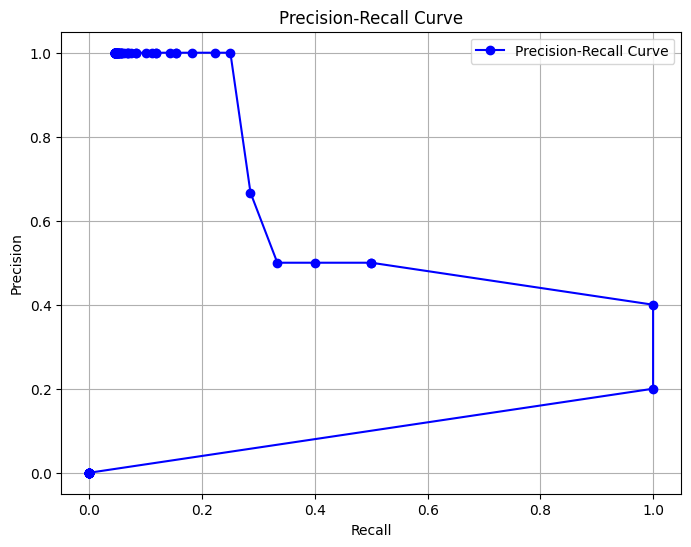

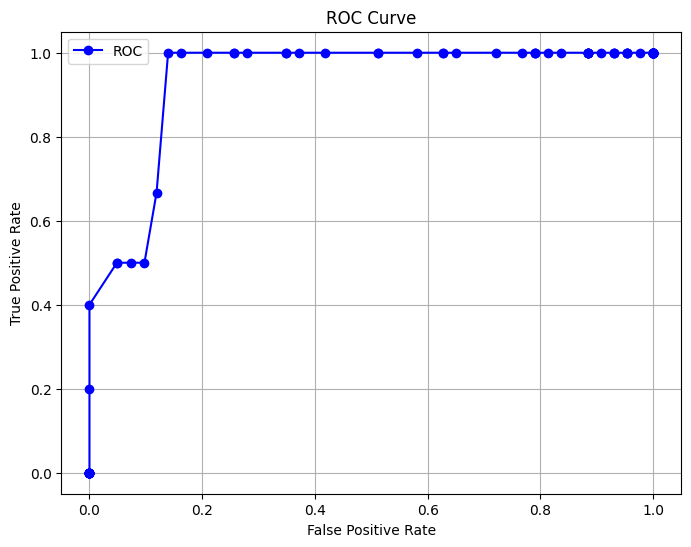

High Level ROC AUC: 0.9364131751193429
High Level Precision Recall Curve AUC: 0.5158730153734765


In [ ]:
# List of high-level goals 
generated_goals = [goal.description for goal in highLevelGoals.goals]
manual_goals = ["Provide fast and automated annotation of genetic variants", "Enable high-throughput interpretation of genetic variants", "Integrate information from various existing resources", "Convert DNA changes to protein changes", "Predict functional effects of protein mutations", "Provide information about mutation frequencies", "Offer insights into gene function", "Detail variant effects", "Highlight clinical actionability of variants"]

evaluator = GoalEvaluator(preprocess = False)

auc_roc, auc_prec_rec = evaluator.print_roc_prec_rec_curve(generated_goals, manual_goals)
print("High Level ROC AUC:", auc_roc)
print("High Level Precision Recall Curve AUC:", auc_prec_rec)


### Evaluation: Extracted Low Level Goals 

recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837352282 fpr:  0.9999999999982517
recall:  0.9999999998333333 precision:  0.010380622837

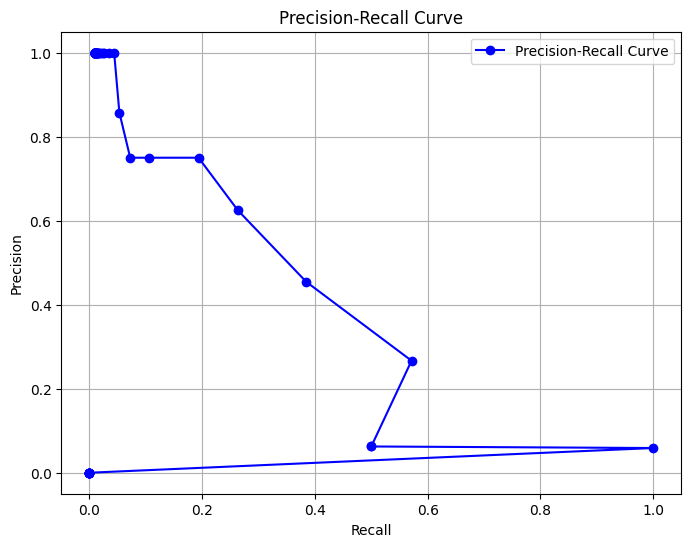

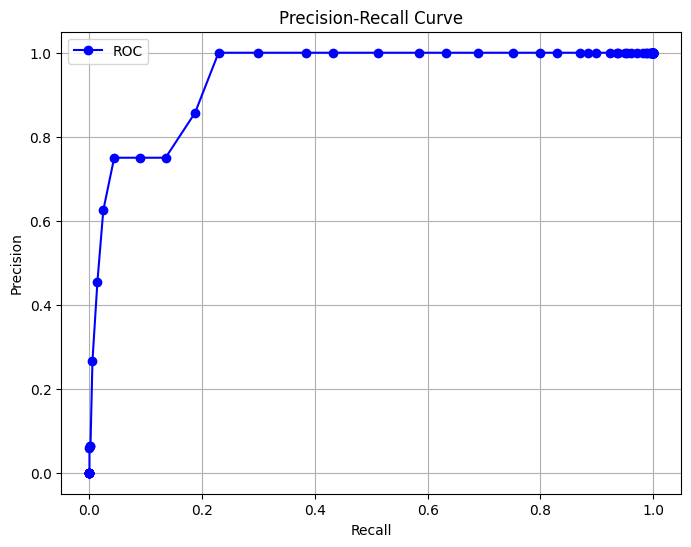

Low Level Goals AUC: 0.9428537166437039


In [ ]:
# List of low-level goals 
generated_low_level_goals = [goal.description for goal in lowLevelGoals.low_level_goals]

manual_low_level_goals = [
    # Provide a comprehensive one-stop resource for genetic variant annotation
    "Retrieve genetic variant data from multiple databases (e.g., dbSNP, ClinVar, COSMIC)",
    "Search and retrieve variant annotations from a user interface",
    "Annotate variants with clinical significance, mutation types, and related diseases",
    "Map genetic data to genome assemblies (e.g., GRCh38, hg19)",
    "Update variant information regularly from authoritative sources",
    
    # Enable fast and automated interpretation of cancer-related genetic variants
    "Analyze cancer-related mutations using automated tools",
    "Integrate gene expression data for cancer variant interpretation",
    "Identify cancer-related mutations linked to specific pathways",
    "Interpret large-scale cancer mutation datasets automatically",
    "Classify cancer mutations based on clinical relevance",
    
    # Support high-throughput analysis of genetic mutations
    "Process large genomic datasets in parallel",
    "Extract and transform mutation data from high-throughput sequencing formats (e.g., VCF, BAM)",
    "Perform mutation quality control and filtering",
    
    # Integrate data from multiple genomic databases
    "Fetch and harmonize data from various genomic databases",
    "Query integrated genomic databases for relevant mutation information",
    "Integrate multiple data sources with compatible formats for easy retrieval",
    
    # Convert DNA changes to corresponding protein changes
    "Map genetic mutations to corresponding protein-coding effects",
    "Convert mutations to amino acid changes for protein function analysis",
    "Predict the impact of mutations on protein structure using bioinformatics tools",
    
    # Predict the functional impact of protein mutations
    "Use prediction tools (e.g., PolyPhen, SIFT) to estimate mutation effects on protein function",
    "Build and apply machine learning models for functional impact prediction",
    "Rank mutations based on predicted severity of functional impact",
    
    # Provide information on mutation frequencies across datasets
    "Calculate mutation frequencies across various population groups",
    "Generate visual representations of mutation frequencies (e.g., histograms, pie charts)",
    "Provide mutation frequency data for specific diseases or conditions",
    
    # Offer insights into gene function and biological relevance
    "Retrieve gene function annotations from public databases like Gene Ontology (GO)",
    "Identify pathways and biological processes related to the mutated gene",
    "Link genetic variants to specific diseases or phenotypes based on annotations",
    
    # Detail the effects of genetic variants on protein function
    "Predict the effects of mutations on protein folding and stability",
    "Identify how mutations alter protein activity or structure",
    "Evaluate the impact of mutations on protein-protein interactions",
    
    # Highlight the clinical actionability of specific mutations
    "Link genetic mutations to clinical guidelines or treatment protocols",
    "Identify mutations with known clinical drug responses or therapeutic implications",
    "Provide actionable insights on mutations based on current clinical research"
]

evaluator_low_level = GoalEvaluator(preprocess = False)

auc_roc, auc_prec_rec = evaluator_low_level.print_roc_prec_rec_curve(generated_low_level_goals, manual_low_level_goals)
print("Low Level Goals ROC AUC:", auc_roc)
print("Low Level Goals Precision Recall Curve AUC:", auc_prec_rec)

### Evaluation: Extracted Actors 

recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.16666666665277777 fpr:  0.9999999999
recall:  0.9999999995 precision:  0.166666666652777

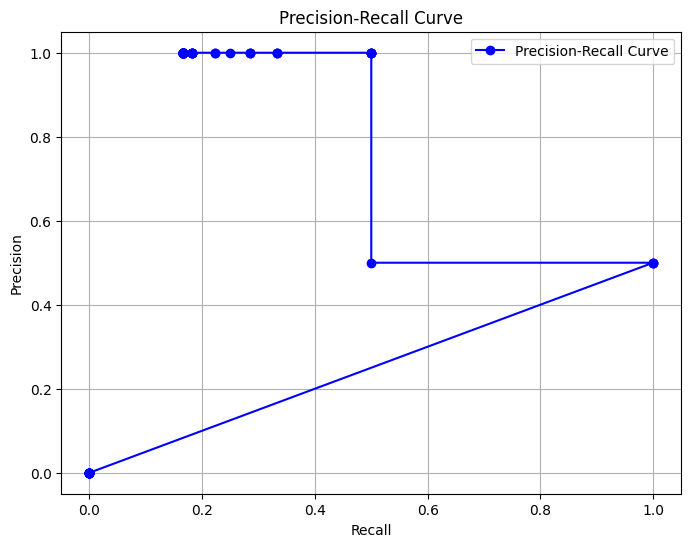

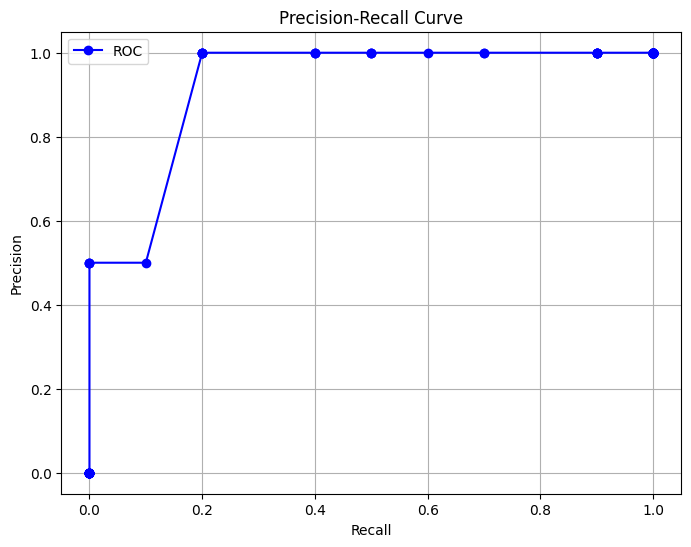

Actors AUC: 0.924999999445


In [ ]:
# List of actors
generated_actors = [actor.name for actor in actors.actors]
manual_actors = [
    "Researchers", "Clinicians", "biologists", "Database Administrators", "Bioinformaticians", "Geneticists"
]

evaluator = GoalEvaluator(preprocess = False)

auc_roc, auc_prec_rec = evaluator.print_roc_prec_rec_curve(generated_actors, manual_actors)
print("Actors ROC AUC:", auc_roc)
print("Actors Precision Recall Curve AUC:", auc_prec_rec)